<a href="https://colab.research.google.com/github/cammylexi/CS2341-Assignment-3/blob/main/Copy_of_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search: Solving a Maze Using a Goal-based Agent

Student Name: Camryn McPhaul

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: CM

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for planning paths through mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

In this exercise, we will implement the planning function for a type of goal-based agent called a __planning agent__. The planning function uses a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. We will only focus on the planning function, so you do not need to implement an environment, just use the map to search for a path to solve the maze.

Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the plan step-by-step and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. I will show you a short example, but you do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [51]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Datasets')

!pip install numpy matplotlib

# Then try importing again
import maze_helper as mh

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [53]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

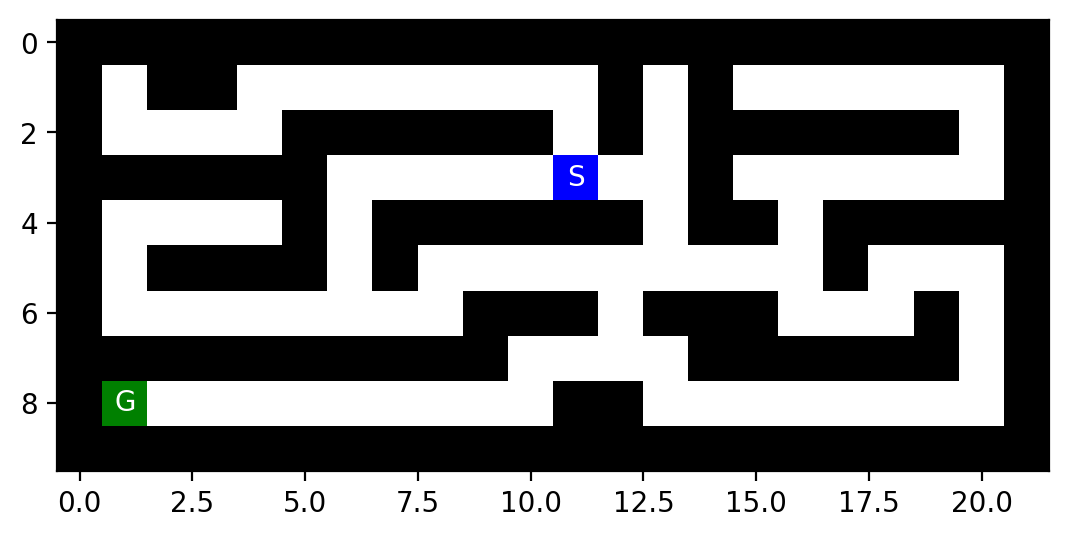

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [55]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [56]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        (Experimental) Build an animation from a list of mazes.

        Parameters:
            result: a list with the elements path, reached, actions and maze_anim with a list of maze arrays that contain what you want to visualize.
            repeat: if True, the animation will repeat.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
            maze: a array with characters produced by parse_maze()
            what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
            a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## An Example for a Planning Agent

I will show you here how to implement a simple agent that uses a random plan. It will not solve the maze, but show you how the mechanics work.

First, we define a generic planning agent that fist plans, and then executes the plan step-by-step.

In [57]:
class Planning_Agent:
    def __init__(self, maze, start, goal, planning_function):
        self.maze = maze
        self.start = start
        self.goal = goal
        self.planning_function = planning_function
        self.plan = None
        self.progress = None

    def act(self):
        # plan if no plan exists
        if self.plan is None:
            print("Planning...")
            self.plan = self.planning_function(self.maze, self.start, self.goal)
            self.progress = 0

        # check if plan is completed
        if self.progress >= len(self.plan):
            raise Exception("Completed Plan. No more planned actions")

        # follow the plan
        action = self.plan[self.progress]
        print(f"Following plan... step {self.progress}: {action}")

        self.progress += 1
        return action

Next, we define the planning function. This function is what you will implement in this assignment.  

In [58]:
import numpy as np

def plan_random(maze, start, goal):
    """Create a random plan with 10 steps"""
    plan = np.random.choice(["N", "E", "S", "W"], size=10, replace=True).tolist()
    return plan

plan_random(maze, (1,1), (8,8))

['E', 'N', 'S', 'N', 'S', 'W', 'E', 'E', 'S', 'W']

This planning function is not great and will not produce a plan that solves the maze. Your planning functions will do better.

Finally, we can create the planning agent, give it the planning function and implement a simple environment that asks it 11 times for an action.

In [59]:
my_agent = Planning_Agent(maze, mh.find_pos(maze, what = "S"), mh.find_pos(maze, what = "G"), plan_random)

def environment(agent_function, steps):
    for _ in range(steps):
        try:
            agent_function()
        except Exception as e:
            print(f"Agent exception: {e}")

environment(my_agent.act, steps=11)

Planning...
Following plan... step 0: W
Following plan... step 1: E
Following plan... step 2: E
Following plan... step 3: S
Following plan... step 4: W
Following plan... step 5: E
Following plan... step 6: W
Following plan... step 7: N
Following plan... step 8: N
Following plan... step 9: W
Agent exception: Completed Plan. No more planned actions


Note: The agent and environment implementation above is just an illustration. You will only implement and experiment with different versions of the planning function.

## Tree structure

To use tree search, you will need to implement a tree data structure in Python.
Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [60]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

* Initial state
  -  The start of the maze labeled "S"
* Actions
  - The direction the agent can take North, South, East, and West
* Transition model
  - The movement of the agent
* Goal state
  - The finish state of the maze labeled "G", when the maze is completed
* Path cost
  - Each step on the path cost one

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

* $n$: state space size
  -  The number of white spaces in the  environment
* $d$: depth of the optimal solution
  - Calculate the path with the least amount of spaces from intial state to the solution state
* $m$: maximum depth of tree
  -  By finding the max length of the longest path with loops removed.
* $b$: maximum branching factor
  - By calculating the max number of avaliable actions in the search tree

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [61]:
import numpy as np
from collections import deque
import maze_helper as mh
import pandas as pd
from IPython.display import HTML, display


class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)


In [62]:
# ---------- helpers ----------
DIRECTIONS = {"N": (-1, 0), # North: row - 1
              "E": (0, 1),  # East: col + 1
              "S": (1, 0),  # South: row + 1
              "W": (0, -1)} # West: col - 1

def get_valid_actions(maze, pos):
    """
    Returns list of valid (action, new_position) pairs from current position.
    Returns in consistent order: N, E, S, W
    """
    valid_actions = []
    row, col = pos

    # Check in consistent order: N, E, S, W
    for action in ["N", "E", "S", "W"]:
        dr, dc = DIRECTIONS[action]
        new_row, new_col = row + dr, col + dc

        # Check bounds
        if 0 <= new_row < maze.shape[0] and 0 <= new_col < maze.shape[1]:
            # Check if not a wall
            if maze[new_row, new_col] != 'X':
                valid_actions.append((action, (new_row, new_col)))

    return valid_actions

    return valid_actions

def nodes_to_positions(path_nodes):
    """[Node, Node, ...] -> [(r,c), ...]"""
    return [n.pos for n in path_nodes] if path_nodes else []

def nodes_to_actions(path_nodes):
    """[Node, Node, ...] -> ['N','E','S','W', ...]  (root has action=None)"""
    if not path_nodes:
        return []
    return [n.action for n in path_nodes[1:]]  # skip root

def move(maze, pos, action):
    if action not in DIRECTIONS:
        return None
    dr, dc = DIRECTIONS[action]
    r, c = pos
    new_pos = (r + dr, c + dc)
    if 0 <= new_pos[0] < len(maze) and 0 <= new_pos[1] < len(maze[0]):
        return new_pos
    return None

def valid_neighbors(maze, pos, actions=("N","E","S","W")):
    for a in actions:
        new_pos = move(maze, pos, a)
        if new_pos is None:
            continue
        cell = mh.look(maze, new_pos)   # read-only; walls '#'
        if cell is None or cell == '#':
            continue
        yield a, new_pos


In [63]:
# ---------- BFS (graph-search) + animation frames (no map writes) ----------
import numpy as np
import maze_helper as mh
from collections import deque

def _bfs_neighbors(maze, pos):
    r, c = pos
    H, W = maze.shape
    for action, (dr, dc) in [('N',(-1,0)), ('E',(0,1)), ('S',(1,0)), ('W',(0,-1))]:
        nr, nc = r+dr, c+dc
        if 0 <= nr < H and 0 <= nc < W and maze[nr, nc] not in ('X', '#'):
            yield (nr, nc), action

def _snapshot(maze, frontier_positions, explored, path=None):
    """
    Build a single animation frame by overlaying symbols on a COPY of the maze.
    We do NOT mutate the original maze.
    Legend used by animate helper (adjust if your helper expects different):
      '.' = explored (dequeued)
      'F' = frontier (enqueued)
      'P' = final path overlay
    """
    M = np.copy(maze)
    for (r,c) in explored:
        if M[r,c] == ' ':
            M[r,c] = '.'
    for (r,c) in frontier_positions:
        if M[r,c] == ' ':
            M[r,c] = 'F'
    if path:
        for (r,c) in path:
            if M[r,c] in (' ', '.', 'F'):
                M[r,c] = 'P'
    return M

def bfs_graph_search_with_anim(maze):
    """
    Breadth-First Search (graph-search):
    - frontier = FIFO queue of Nodes
    - reached = set of discovered states (no map writes)
    Returns dict including 'maze_anim' for mh.animate_maze.
    """
    start = tuple(mh.find_pos(maze, 'S'))
    goal  = tuple(mh.find_pos(maze, 'G'))

    start_node = Node(start, None, None, 0)
    if start == goal:
        # minimal animation: just show start and final path
        path = [start]
        maze_anim = [_snapshot(maze, [], set()), _snapshot(maze, [], set(), path)]
        return {
            'node': start_node, 'path': path, 'actions': [], 'cost': 0,
            'nodes_expanded': 0, 'reached': {start}, 'maze_anim': maze_anim
        }

    frontier = deque([start_node])
    reached  = {start}
    explored = set()
    nodes_expanded = 0

    # initial frame (frontier only)
    maze_anim = [_snapshot(maze, [n.pos for n in frontier], explored)]

    while frontier:
        node = frontier.popleft()
        explored.add(node.pos)

        # frame after pop
        maze_anim.append(_snapshot(maze, [n.pos for n in frontier], explored))

        if node.pos == goal:
            path_nodes = node.get_path_from_root()
            path = [n.pos for n in path_nodes]
            actions = [n.action for n in path_nodes[1:]] if len(path_nodes) > 1 else []
            # final overlay with path
            maze_anim.append(_snapshot(maze, [], explored, path))
            return {
                'node': node, 'path': path, 'actions': actions, 'cost': node.cost,
                'nodes_expanded': nodes_expanded, 'reached': reached, 'maze_anim': maze_anim
            }

        nodes_expanded += 1

        for nxt, act in _bfs_neighbors(maze, node.pos):
            if nxt in reached:
                continue
            reached.add(nxt)
            child = Node(nxt, node, act, node.cost + 1)
            frontier.append(child)

        # frame after pushing children
        maze_anim.append(_snapshot(maze, [n.pos for n in frontier], explored))

    # failure
    return {
        'node': None, 'path': None, 'actions': None, 'cost': float('inf'),
        'nodes_expanded': nodes_expanded, 'reached': reached, 'maze_anim': maze_anim
    }

# --- wrapper used by your cell ---
def run_bfs(maze_str):
    maze = mh.parse_maze(maze_str)
    res  = bfs_graph_search_with_anim(maze)
    ani  = mh.animate_maze(res)
    return ani, res


In [64]:
def run_bfs(maze_str):
    maze = mh.parse_maze(maze_str)
    res  = bfs_graph_search_with_anim(maze)
    ani  = mh.animate_maze(res)
    return ani, res

with open("small_maze.txt","r") as f:
    small_maze_str = f.read()

ani, bfs_result = run_bfs(small_maze_str)
display(ani)  # in a notebook
print("BFS cost:", bfs_result["cost"], "expanded:", bfs_result["nodes_expanded"])


Path length: 19
Reached squares: 94
Action sequence: ['E', 'E', 'S', 'S', 'W', 'S', 'S', 'W', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']


BFS cost: 19 expanded: 92


In [65]:
with open("medium_maze.txt","r") as f:
    medium_maze_str = f.read()

ani, bfs_result = run_bfs(medium_maze_str)
display(ani)  # in a notebook
print("BFS cost:", bfs_result["cost"], "expanded:", bfs_result["nodes_expanded"])

Path length: 68
Reached squares: 272
Action sequence: ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'E', 'E', 'S', 'S', 'S', 'W', 'W', 'W', 'N', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']


BFS cost: 68 expanded: 269


#DFS

In [ ]:
import numpy as np
import maze_helper as mh

# ---------- DFS (tree-search) with cycle checking + animation frames ----------

def _dfs_neighbors(maze, pos):
    r, c = pos
    H, W = maze.shape
    # Order controls DFS bias. Adjust to your spec.
    for action, (dr, dc) in [('N',(-1,0)), ('E',(0,1)), ('S',(1,0)), ('W',(0,-1))]:
        nr, nc = r+dr, c+dc
        if 0 <= nr < H and 0 <= nc < W and maze[nr, nc] != 'X':   # walls are 'X'
            yield (nr, nc), action

def _snapshot(maze, stack_positions, explored, path=None):
    """Build a single frame for the animator."""
    M = np.copy(maze)
    for (r,c) in explored:
        if M[r,c] == ' ': M[r,c] = '.'
    for (r,c) in stack_positions:
        if M[r,c] == ' ': M[r,c] = 'F'
    if path:
        for (r,c) in path:
            if M[r,c] in (' ', '.', 'F'):
                M[r,c] = 'P'
    return M

def dfs_tree_cyclecheck_with_anim(maze):
    """
    Depth-First Search WITHOUT global reached/pruning.
    Only checks cycles along the current path (ancestor set).
    Returns result dict expected by mh.animate_maze.
    """
    start = tuple(mh.find_pos(maze, 'S'))
    goal  = tuple(mh.find_pos(maze, 'G'))

    start_node = Node(start, None, None, 0)
    # stack elements: (node, path_set)
    stack = [(start_node, {start})]

    nodes_expanded = 0
    explored = set()        # for animation only: nodes we've popped
    reached  = set([start]) # for animation only: every node we ever discover
    maze_anim = [_snapshot(maze, [n.pos for (n,_) in stack], explored)]

    while stack:
        node, path_set = stack.pop()
        explored.add(node.pos)

        # frame after pop
        maze_anim.append(_snapshot(maze, [n.pos for (n,_) in stack], explored))

        if node.pos == goal:
            path_nodes = node.get_path_from_root()
            path = [n.pos for n in path_nodes]
            actions = [n.action for n in path_nodes[1:]] if len(path_nodes) > 1 else []
            # final path overlay
            maze_anim.append(_snapshot(maze, [], explored, path))
            return {
                'node': node,
                'path': path,
                'actions': actions,
                'cost': node.cost,
                'nodes_expanded': nodes_expanded,
                'reached': reached,      # stats only (not used for pruning)
                'maze_anim': maze_anim
            }

        nodes_expanded += 1

        # Generate children; push in reverse so the first neighbor listed is explored first.
        nbrs = list(_dfs_neighbors(maze, node.pos))
        for (nxt, act) in reversed(nbrs):
            if nxt in path_set:              # cycle check (ancestor only)
                continue
            child = Node(nxt, node, act, node.cost + 1)
            new_path = set(path_set); new_path.add(nxt)
            stack.append((child, new_path))
            reached.add(nxt)                 # for animation only

        # frame after pushing children
        maze_anim.append(_snapshot(maze, [n.pos for (n,_) in stack], explored))

    # failure
    return {
        'node': None,
        'path': None,
        'actions': None,
        'cost': float('inf'),
        'nodes_expanded': nodes_expanded,
        'reached': reached,
        'maze_anim': maze_anim
    }

# Convenience runner (returns the animation object and the raw result)
def run_dfs(maze_str):
    maze = mh.parse_maze(maze_str)
    res  = dfs_tree_cyclecheck_with_anim(maze)
    ani  = mh.animate_maze(res)
    return ani, res


In [ ]:
with open("small_maze.txt","r") as f:
    small_maze_str = f.read()

ani, dfs_result = run_dfs(small_maze_str)
display(ani)  # in a notebook
print("DFS depth:", dfs_result["cost"], "expanded:", dfs_result["nodes_expanded"])


In [ ]:
with open("medium_maze.txt","r") as f:
    small_maze_str = f.read()

ani, dfs_result = run_dfs(small_maze_str)
display(ani)  # in a notebook
print("DFS depth:", dfs_result["cost"], "expanded:", dfs_result["nodes_expanded"])

In [ ]:
with open("large_maze.txt","r") as f:
    small_maze_str = f.read()

ani, dfs_result = run_dfs(small_maze_str)
display(ani)  # in a notebook
print("DFS depth:", dfs_result["cost"], "expanded:", dfs_result["nodes_expanded"])

In [ ]:
with open("open_maze.txt","r") as f:
    open_maze_str = f.read()

ani, dfs_result = run_dfs(open_maze_str)
display(ani)  # in a notebook
print("DFS depth:", dfs_result["cost"], "expanded:", dfs_result["nodes_expanded"])

In [ ]:
def DFS_iterative(maze, max_depth=1000):
    """
    DFS with cycle checking using path positions.
    """
    start = tuple(mh.find_pos(maze, what="S"))
    goal = tuple(mh.find_pos(maze, what="G"))

    root = Node(start, parent=None, action=None, cost=0)
    stack = [(root, {start})]

    nodes_expanded = 0
    max_frontier = 1
    max_depth_reached = 0
    visited = [start]
    frontier_history = []

    while stack:
        max_frontier = max(max_frontier, len(stack))

        frontier_positions = [node.pos for node, _ in stack]
        frontier_history.append((list(visited), frontier_positions.copy()))

        node, path_positions = stack.pop()
        nodes_expanded += 1
        max_depth_reached = max(max_depth_reached, node.cost)

        # Check goal AFTER popping from frontier
        if node.pos == goal:
            path = node.get_path_from_root()
            return {
                "path": path,
                "cost": len(path) - 1,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth_reached,
                "max_frontier": max_frontier,
                "visited": visited,
                "frontier_history": frontier_history
            }

        # Depth limit check
        if node.cost >= max_depth:
            continue

        # Get valid actions
        actions_list = get_valid_actions(maze, node.pos)

        # Add children in reverse order (so first action is explored first)
        for action, new_pos in reversed(actions_list):
            if new_pos not in path_positions:  # Cycle checking
                child = Node(new_pos, parent=node, action=action, cost=node.cost + 1)
                new_path_positions = path_positions | {new_pos}
                stack.append((child, new_path_positions))

                if new_pos not in visited:
                    visited.append(new_pos)

    # No solution found
    return {
        "path": None,
        "cost": None,
        "nodes_expanded": nodes_expanded,
        "max_depth": max_depth_reached,
        "max_frontier": max_frontier,
        "visited": visited,
        "frontier_history": frontier_history
    }

In [ ]:
def load_maze(filename):
    """Load a single maze from file."""
    with open(filename, "r") as f:
        return mh.parse_maze(f.read())

def load_all_mazes():
    """Load all mazes and return as dictionary."""
    maze_files = {
        "small": "small_maze.txt",
        "medium": "medium_maze.txt",
        "large": "large_maze.txt",
        "open": "open_maze.txt",
        #"wall": "wall_maze.txt",
        "loops": "loops_maze.txt",
        "empty": "empty_maze.txt",
        "empty_2": "empty_2_maze.txt"
    }

    mazes = {}
    for name, file in maze_files.items():
        try:
            mazes[name] = load_maze(file)
            print(f"Loaded {name} maze")
        except FileNotFoundError:
            print(f"Could not find {file}")

    print(f"\nTotal: {len(mazes)} mazes loaded\n")
    return mazes

In [ ]:
def nodes_to_positions(path_nodes):
    """Convert list of Node objects to list of positions."""
    return [n.pos for n in path_nodes] if path_nodes else []

def nodes_to_actions(path_nodes):
    """Convert list of Node objects to list of actions."""
    if not path_nodes:
        return []
    return [n.action for n in path_nodes[1:]]  # skip root node

def print_single_result(result, algorithm_name, maze_name):
    """Print formatted results for a single algorithm run."""
    print(f"\n{algorithm_name} on {maze_name} maze:")
    print("-" * 50)

    if result["path"]:
        print(f"  Path Cost:         {result['cost']}")
        print(f"  Nodes Expanded:    {result['nodes_expanded']}")
        print(f"  Max Tree Depth:    {result['max_depth']}")
        print(f"  Max Frontier Size: {result['max_frontier']}")
        print(f"  Actions: {nodes_to_actions(result['path'])}")
    else:
        print(f"  No solution found")
        print(f"  Nodes Expanded: {result['nodes_expanded']}")


In [ ]:
def run_algorithm_on_maze(algorithm_func, maze, maze_name, alg_name):
    """Run a single algorithm on a single maze and return results."""

    try:
        result = algorithm_func(maze)
        if result["path"]:
            print(f"Success! (cost={result['cost']})")
        else:
            print("No solution found")
        return result
    except Exception as e:
        print(f"Error: {e}")
        return None



def create_visualization_maze(maze, result):
    """
    Create a maze visualization with visited cells and path marked.

    Args:
        maze: original maze array
        result: algorithm result dict with 'visited' and 'path'

    Returns:
        Modified maze array with markings
    """
    viz_maze = maze.copy()

    # Mark visited cells with '.'
    for pos in result["visited"]:
        if viz_maze[pos] == ' ':
            viz_maze[pos] = '.'

    # Mark path with 'P' (overwrites visited markers)
    for node in result["path"]:
        if viz_maze[node.pos] not in ['S', 'G']:
            viz_maze[node.pos] = 'P'

    return viz_maze

def visualize_single_solution(maze, result, alg_name, maze_name):
    """Display visualization for a single algorithm result."""
    if result and result["path"]:
        print(f"\n{alg_name} on {maze_name} - "
              f"Cost={result['cost']}, Expanded={result['nodes_expanded']}")

        viz_maze = create_visualization_maze(maze, result)
        mh.show_maze(viz_maze)
    else:
        print(f"\n{alg_name} on {maze_name}: No solution to visualize")



def create_animation(maze, result, alg_name, maze_name):
    """Create animation for a single result showing algorithm progression."""
    if not (result and result["path"]):
        print(f"{alg_name} on {maze_name}: No solution to animate")
        return

    try:
        # Create list of maze frames for animation
        maze_frames = []
        visited_list = list(result["visited"])
        path_positions = nodes_to_positions(result["path"])

        # Phase 1: Show exploration - one frame per visited cell
        for i in range(len(visited_list)):
            frame = maze.copy()

            # Mark all cells visited so far with '.' (gray)
            for pos in visited_list[:i+1]:
                if frame[pos] == ' ':
                    frame[pos] = '.'

            maze_frames.append(frame)

        # Phase 2: Show final path - one frame per path step
        for i in range(len(path_positions)):
            frame = maze.copy()

            # Mark all visited cells
            for pos in visited_list:
                if frame[pos] == ' ':
                    frame[pos] = '.'

            # Mark path up to current position with 'P' (red)
            for pos in path_positions[:i+1]:
                if frame[pos] not in ['S', 'G']:
                    frame[pos] = 'P'

            maze_frames.append(frame)

        # Package data in format animate_maze expects
        animation_data = {
            "path": path_positions,
            "reached": visited_list,
            "actions": nodes_to_actions(result["path"]),
            "maze_anim": maze_frames  # This is the key part!
        }

        # Create and display animation
        anim = mh.animate_maze(animation_data, repeat=False)
        display(HTML(anim.to_jshtml()))

    except Exception as e:
        print(f"Animation failed for {alg_name} on {maze_name}: {e}")
        print("Showing static visualization instead...")
        visualize_single_solution(maze, result, alg_name, maze_name)

In [ ]:
small_maze = load_maze("small_maze.txt")

# BFS
print("\n--- BFS ---")
bfs_small = run_algorithm_on_maze(BFS, small_maze, "small", "BFS")
if bfs_small:
    print_single_result(bfs_small, "BFS", "small")
    visualize_single_solution(small_maze, bfs_small, "BFS", "small")
    #create_animation(small_maze, bfs_small, "BFS", "small")

In [ ]:
print("="*70)
print("TASK 2: UNINFORMED SEARCH - INDIVIDUAL MAZE TESTING")
print("="*70)

# ----------------------------------------------------------------------------
# SMALL MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("SMALL MAZE")
print("="*70)

small_maze = load_maze("small_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on small maze
print("--- BFS ---")
bfs_small = run_algorithm_on_maze(BFS, small_maze, "small", "BFS")
if bfs_small:
    print_single_result(bfs_small, "BFS", "small")
    visualize_single_solution(small_maze, bfs_small, "BFS", "small")
    create_animation(small_maze, bfs_small, "BFS", "small")

# DFS on small maze
print("\n--- DFS ---")
dfs_small = run_algorithm_on_maze(DFS_iterative, small_maze, "small", "DFS")
if dfs_small:
    print_single_result(dfs_small, "DFS", "small")
    visualize_single_solution(small_maze, dfs_small, "DFS", "small")
    #create_animation(small_maze, dfs_small, "DFS", "small")



In [ ]:
# ----------------------------------------------------------------------------
# MEDIUM MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("MEDIUM MAZE")
print("="*70)

medium_maze = load_maze("medium_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on medium maze
print("--- BFS ---")
bfs_medium = run_algorithm_on_maze(BFS, medium_maze, "medium", "BFS")
if bfs_medium:
    print_single_result(bfs_medium, "BFS", "medium")
    visualize_single_solution(medium_maze, bfs_medium, "BFS", "medium")
    #create_animation(medium_maze, bfs_medium, "BFS", "medium")


In [ ]:
# ----------------------------------------------------------------------------
# LARGE MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("LARGE MAZE")
print("="*70)

large_maze = load_maze("large_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on large maze
print("--- BFS ---")
bfs_large = run_algorithm_on_maze(BFS, large_maze, "large", "BFS")
if bfs_large:
    print_single_result(bfs_large, "BFS", "large")
    visualize_single_solution(large_maze, bfs_large, "BFS", "large")
    #create_animation(large_maze, bfs_large, "BFS", "large")

In [ ]:
# ----------------------------------------------------------------------------
# OPEN MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("OPEN MAZE")
print("="*70)

open_maze = load_maze("open_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on open maze
print("--- BFS ---")
bfs_open = run_algorithm_on_maze(BFS, open_maze, "open", "BFS")
if bfs_open:
    print_single_result(bfs_open, "BFS", "open")
    visualize_single_solution(open_maze, bfs_open, "BFS", "open")
    #create_animation(open_maze, bfs_open, "BFS", "open")


In [ ]:
# ----------------------------------------------------------------------------
# LOOPS MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("LOOPS MAZE")
print("="*70)

loops_maze = load_maze("loops_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on loops maze
print("--- BFS ---")
bfs_loops = run_algorithm_on_maze(BFS, loops_maze, "loops", "BFS")
if bfs_loops:
    print_single_result(bfs_loops, "BFS", "loops")
    visualize_single_solution(loops_maze, bfs_loops, "BFS", "loops")
    #create_animation(loops_maze, bfs_loops, "BFS", "loops")


In [ ]:
# ----------------------------------------------------------------------------
# LOOPS MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("LOOPS MAZE")
print("="*70)

loops_maze = load_maze("loops_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on loops maze
print("--- BFS ---")
bfs_loops = run_algorithm_on_maze(BFS, loops_maze, "loops", "BFS")
if bfs_loops:
    print_single_result(bfs_loops, "BFS", "loops")
    visualize_single_solution(loops_maze, bfs_loops, "BFS", "loops")
    #create_animation(loops_maze, bfs_loops, "BFS", "loops")


In [ ]:
# ----------------------------------------------------------------------------
# EMPTY MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("EMPTY MAZE")
print("="*70)

empty_maze = load_maze("empty_maze.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on empty maze
print("--- BFS ---")
bfs_empty = run_algorithm_on_maze(BFS, empty_maze, "empty", "BFS")
if bfs_empty:
    print_single_result(bfs_empty, "BFS", "empty")
    visualize_single_solution(empty_maze, bfs_empty, "BFS", "empty")
    #create_animation(empty_maze, bfs_empty, "BFS", "empty")


In [ ]:
# ----------------------------------------------------------------------------
# EMPTY 2 MAZE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("EMPTY 2 MAZE")
print("="*70)

empty_2_maze = load_maze("empty_maze_2.txt")
print("\nMaze loaded. Running algorithms...\n")

# BFS on empty 2 maze
print("--- BFS ---")
bfs_empty_2 = run_algorithm_on_maze(BFS, empty_2_maze, "empty_2", "BFS")
if bfs_empty_2:
    print_single_result(bfs_empty_2, "BFS", "empty_2")
    visualize_single_solution(empty_2_maze, bfs_empty_2, "BFS", "empty_2")
    #create_animation(empty_2_maze, bfs_empty_2, "BFS", "empty_2")

#DSF



In [ ]:
# Test with small maze
print("="*70)
print("SMALL MAZE")
print("="*70)

small_maze = load_maze("small_maze.txt")

# DFS on small maze
print("\n--- DFS ---")
dfs_small = run_algorithm_on_maze(DFS_iterative, small_maze, "small", "DFS")
if dfs_small:
    print_single_result(dfs_small, "DFS", "small")
    create_animation(small_maze, dfs_small, "DFS", "small")

In [ ]:

# DFS on medium maze
print("\n--- DFS ---")
dfs_medium = run_algorithm_on_maze(DFS_iterative, medium_maze, "medium", "DFS")
if dfs_medium:
    print_single_result(dfs_medium, "DFS", "medium")
    visualize_single_solution(medium_maze, dfs_medium, "DFS", "medium")
    #create_animation(medium_maze, dfs_medium, "DFS", "medium")

In [ ]:
# DFS on large maze
print("\n--- DFS ---")
dfs_large = run_algorithm_on_maze(DFS_iterative, large_maze, "large", "DFS")
if dfs_large:
    print_single_result(dfs_large, "DFS", "large")
    visualize_single_solution(large_maze, dfs_large, "DFS", "large")
    #create_animation(large_maze, dfs_large, "DFS", "large")

In [ ]:
# DFS on loops maze
print("\n--- DFS ---")
dfs_loops = run_algorithm_on_maze(DFS_iterative, loops_maze, "loops", "DFS")
if dfs_loops:
    print_single_result(dfs_loops, "DFS", "loops")
    visualize_single_solution(loops_maze, dfs_loops, "DFS", "loops")
    #create_animation(loops_maze, dfs_loops, "DFS", "loops")

In [ ]:
# DFS on empty maze
print("\n--- DFS ---")
dfs_empty = run_algorithm_on_maze(DFS_iterative, empty_maze, "empty", "DFS")
if dfs_empty:
    print_single_result(dfs_empty, "DFS", "empty")
    visualize_single_solution(empty_maze, dfs_empty, "DFS", "empty")
    #create_animation(empty_maze, dfs_empty, "DFS", "empty")

In [ ]:
# DFS on empty 2 maze
print("\n--- DFS ---")
dfs_empty_2 = run_algorithm_on_maze(DFS_iterative, empty_2_maze, "empty_2", "DFS")
if dfs_empty_2:
    print_single_result(dfs_empty_2, "DFS", "empty_2")
    visualize_single_solution(empty_2_maze, dfs_empty_2, "DFS", "empty_2")
    #create_animation(empty_2_maze, dfs_empty_2, "DFS", "empty_2")

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [ ]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [ ]:
# Discussion

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:
def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

In [ ]:
import heapq

# ---------- GBFS (Greedy Best-First Search) ----------
def GBFS(maze):
    """
    Greedy Best-First Search using Manhattan distance as heuristic.
    Expands nodes with lowest h(n) - estimated cost to goal.
    """
    start = tuple(mh.find_pos(maze, what="S"))
    goal = tuple(mh.find_pos(maze, what="G"))

    root = Node(start, parent=None, action=None, cost=0)

    # Priority queue: (h(n), counter, node)
    # counter prevents comparison issues when h values are equal
    counter = 0
    frontier = [(manhattan(start, goal), counter, root)]
    heapq.heapify(frontier)

    reached = {start: manhattan(start, goal)}  # pos -> h(n)

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0
    visited = [start]
    frontier_history = []

    while frontier:
        max_frontier = max(max_frontier, len(frontier))

        frontier_positions = [node.pos for _, _, node in frontier]
        frontier_history.append((list(visited), frontier_positions.copy()))

        _, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos == goal:
            path = node.get_path_from_root()
            return {
                "path": path,
                "cost": len(path) - 1,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth,
                "max_frontier": max_frontier,
                "visited": visited,
                "frontier_history": frontier_history
            }

        for action, new_pos in get_valid_actions(maze, node.pos):
            h_new = manhattan(new_pos, goal)

            # Add if not reached, or if we found a better heuristic path
            if new_pos not in reached or h_new < reached[new_pos]:
                child = Node(new_pos, parent=node, action=action, cost=node.cost + 1)
                reached[new_pos] = h_new

                counter += 1
                heapq.heappush(frontier, (h_new, counter, child))

                if new_pos not in visited:
                    visited.append(new_pos)

    return {
        "path": None,
        "cost": None,
        "nodes_expanded": nodes_expanded,
        "max_depth": max_depth,
        "max_frontier": max_frontier,
        "visited": visited,
        "frontier_history": frontier_history
    }

In [ ]:
# ---------- A* Search ----------
def AStar(maze):
    """
    A* Search using f(n) = g(n) + h(n).
    g(n) = actual cost from start
    h(n) = Manhattan distance to goal (heuristic)
    """
    start = tuple(mh.find_pos(maze, what="S"))
    goal = tuple(mh.find_pos(maze, what="G"))

    root = Node(start, parent=None, action=None, cost=0)

    # Priority queue: (f(n), counter, node)
    # f(n) = g(n) + h(n)
    counter = 0
    h_start = manhattan(start, goal)
    f_start = 0 + h_start
    frontier = [(f_start, counter, root)]
    heapq.heapify(frontier)

    reached = {start: 0}  # pos -> g(n) - best known cost to reach this position

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0
    visited = [start]
    frontier_history = []

    while frontier:
        max_frontier = max(max_frontier, len(frontier))

        frontier_positions = [node.pos for _, _, node in frontier]
        frontier_history.append((list(visited), frontier_positions.copy()))

        f_val, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos == goal:
            path = node.get_path_from_root()
            return {
                "path": path,
                "cost": len(path) - 1,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth,
                "max_frontier": max_frontier,
                "visited": visited,
                "frontier_history": frontier_history
            }

        for action, new_pos in get_valid_actions(maze, node.pos):
            g_new = node.cost + 1  # g(n) for child

            # Only add if we haven't reached it, or found a better path
            if new_pos not in reached or g_new < reached[new_pos]:
                child = Node(new_pos, parent=node, action=action, cost=g_new)
                reached[new_pos] = g_new

                h_new = manhattan(new_pos, goal)
                f_new = g_new + h_new

                counter += 1
                heapq.heappush(frontier, (f_new, counter, child))

                if new_pos not in visited:
                    visited.append(new_pos)

    return {
        "path": None,
        "cost": None,
        "nodes_expanded": nodes_expanded,
        "max_depth": max_depth,
        "max_frontier": max_frontier,
        "visited": visited,
        "frontier_history": frontier_history
    }

In [ ]:
# ----------------------------------------------------------------------------
# TASK 3: INFORMED SEARCH - GBFS and A*
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("TASK 3: INFORMED SEARCH (GBFS & A*)")
print("="*70)

# Test on small maze first
print("\n" + "="*70)
print("SMALL MAZE - INFORMED SEARCH")
print("="*70)

small_maze = load_maze("small_maze.txt")

# GBFS on small maze
print("\n--- GBFS ---")
gbfs_small = run_algorithm_on_maze(GBFS, small_maze, "small", "GBFS")
if gbfs_small:
    print_single_result(gbfs_small, "GBFS", "small")
    visualize_single_solution(small_maze, gbfs_small, "GBFS", "small")
    #create_animation(small_maze, gbfs_small, "GBFS", "small")


#A* Search

In [ ]:
# A* on small maze
print("\n--- A* ---")
astar_small = run_algorithm_on_maze(AStar, small_maze, "small", "A*")
if astar_small:
    print_single_result(astar_small, "A*", "small")
    visualize_single_solution(small_maze, astar_small, "A*", "small")
    #create_animation(small_maze, astar_small, "A*", "small")

Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
print("\n" + "="*70)
print("TASK 4: RUNNING ALL ALGORITHMS ON ALL MAZES")
print("="*70)

# Load all mazes
mazes = load_all_mazes()

# Dictionary to store all results
all_results = {}

# Run all algorithms on all mazes
algorithms = {
    "BFS": BFS,
    "DFS": DFS_iterative,
    "GBFS": GBFS,
    "A*": AStar
}

for maze_name, maze in mazes.items():
    print(f"\n{'='*70}")
    print(f"Processing: {maze_name.upper()} MAZE")
    print(f"{'='*70}")

    all_results[maze_name] = {}

    for alg_name, alg_func in algorithms.items():
        print(f"\nRunning {alg_name}...")
        result = run_algorithm_on_maze(alg_func, maze, maze_name, alg_name)
        all_results[maze_name][alg_name] = result

        if result and result["path"]:
            print(f"  ✓ Solution found - Cost: {result['cost']}, Nodes: {result['nodes_expanded']}")
        else:
            print(f"  ✗ No solution found")


In [ ]:
# ----------------------------------------------------------------------------
# CREATE SUMMARY TABLES
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("RESULTS SUMMARY TABLES")
print("="*70)

import pandas as pd

for maze_name in all_results.keys():
    print(f"\n{maze_name.upper()} MAZE")
    print("-" * 70)

    table_data = []
    for alg_name in ["BFS", "DFS", "GBFS", "A*"]:
        result = all_results[maze_name][alg_name]

        if result and result["path"]:
            row = {
                "Algorithm": alg_name,
                "Path Cost": result["cost"],
                "Nodes Expanded": result["nodes_expanded"],
                "Max Tree Depth": result["max_depth"],
                "Max Frontier Size": result["max_frontier"]
            }
        else:
            row = {
                "Algorithm": alg_name,
                "Path Cost": "N/A",
                "Nodes Expanded": result["nodes_expanded"] if result else "N/A",
                "Max Tree Depth": "N/A",
                "Max Frontier Size": "N/A"
            }
        table_data.append(row)

    df = pd.DataFrame(table_data)
    print(df.to_string(index=False))


In [ ]:
# ----------------------------------------------------------------------------
# VISUALIZATIONS FOR SELECT MAZES
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("VISUALIZATIONS (Small, Medium, Large mazes)")
print("="*70)

# Visualize small maze solutions
if "small" in all_results:
    for alg_name in ["BFS", "DFS", "GBFS", "A*"]:
        result = all_results["small"][alg_name]
        if result and result["path"]:
            visualize_single_solution(mazes["small"], result, alg_name, "small")

In [ ]:
# ----------------------------------------------------------------------------
# COMPARISON CHARTS
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("COMPARISON CHARTS")
print("="*70)

import matplotlib.pyplot as plt

# Prepare data for charts
maze_names = list(all_results.keys())
alg_names = ["BFS", "DFS", "GBFS", "A*"]

# Chart 1: Path Cost Comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(maze_names))
width = 0.2

for i, alg in enumerate(alg_names):
    costs = []
    for maze in maze_names:
        result = all_results[maze][alg]
        if result and result["path"]:
            costs.append(result["cost"])
        else:
            costs.append(0)
    ax.bar([xi + i*width for xi in x], costs, width, label=alg)

ax.set_xlabel('Maze')
ax.set_ylabel('Path Cost')
ax.set_title('Path Cost Comparison Across Mazes')
ax.set_xticks([xi + width*1.5 for xi in x])
ax.set_xticklabels(maze_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Chart 2: Nodes Expanded Comparison
fig, ax = plt.subplots(figsize=(12, 6))

for i, alg in enumerate(alg_names):
    nodes = []
    for maze in maze_names:
        result = all_results[maze][alg]
        if result:
            nodes.append(result["nodes_expanded"])
        else:
            nodes.append(0)
    ax.bar([xi + i*width for xi in x], nodes, width, label=alg)

ax.set_xlabel('Maze')
ax.set_ylabel('Nodes Expanded')
ax.set_title('Nodes Expanded Comparison Across Mazes')
ax.set_xticks([xi + width*1.5 for xi in x])
ax.set_xticklabels(maze_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Chart 3: Max Frontier Size Comparison
fig, ax = plt.subplots(figsize=(12, 6))

for i, alg in enumerate(alg_names):
    frontier = []
    for maze in maze_names:
        result = all_results[maze][alg]
        if result and result["path"]:
            frontier.append(result["max_frontier"])
        else:
            frontier.append(0)
    ax.bar([xi + i*width for xi in x], frontier, width, label=alg)

ax.set_xlabel('Maze')
ax.set_ylabel('Max Frontier Size')
ax.set_title('Memory Usage (Max Frontier Size) Comparison')
ax.set_xticks([xi + width*1.5 for xi in x])
ax.set_xticklabels(maze_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [ ]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [ ]:
# Your code/answer goes here

### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [ ]:
# Your code/answer goes here

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [ ]:
# Your code/answer goes here